In [1]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# 0. Introduction
Sepsis is a kind severe medical condition that is very difficult to predict and such that can cause a huge consequence if the diagnose is wrong. Every late hour of detecting sepsis decrease 10% survial rate.[] The experiement is carried out as an attempt to use Machine Learning  to assist the doctor in detecting the sepsis case promptly. Particularly, the objective of this experiment is to accurately detect sepsis to save as much life as possible and also save costs of using ICU only for a true sepsis case. The paper describes the process of developing Machine Learning model to predict Sepsis. First, we will analysis the dataset to come up with a Machine Learning pipeline, or techniques designed specifically for the dataset so that we can learn the most of it. Then we will actually implements the technique, and fine-tune models to its best state. Later, we will decide which one has the best performance and the most suitable to the domain.


# 1. EDA
The dataset published by John Hopskin University consists of 599 entries and 10 features, namely patient ID, plasma glucose, blood work result 1-4, body mass index (BMI), patient's age and their insurance status. However, we don't use all of them because patient ID and their insurance is irrelevant to predict Sepsis, so we will remove them from the dataset.

I rename the columns so it will be easier to interpret and refer to later in the experiment.

In [2]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [3]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [4]:
# rename the column so that it's easier to evaluate them later
column_names = {
    "PRG": "BGlucose",
    "PR": "BPressure",
    "PL": "B1",
    "SK": "B2",
    "TS": "B3",
    "BD2": "B4",
    "M11": "BMI"
}
df = df.rename(columns= column_names)

## 1.2 Imbalanced classes
Based on the total number of positive and negative cases, the dataset has imbalanced classes, with a ratio of 1:2 positive to negative respectively. The imbalanced-class dataset adversely effect the performance of the model as it will tend to favor the majority. Since the bias given to class negative, the imbalance would also stop us from predicting class positive, which will go against the objective of the experiment. There are many ways to combat this challenge:
- **Class weight**: We can tune the class weight so that, the model will gravitate toward class 1 when features appeared in both classes. This technique is quick and easy to deploy but as it favors class positive too much, it will produce lots of false positive and we have to be cautious of applying the technique. The recommended  number to start with is a reversed ratio of classes, which mean if our ratio is 1 positive over 2 negative, we will set the weight of class positive to 2 and of class negative to 1.
- **Resampling**: it's a technique to create more samples for the minority, which is called oversampling, or remove samples of the majority class and so it's called undersampling. However, we not going to use it because it will only show clear improvement if the dataset is severely imbalanced, while our ratio is only 1:2. So, it's better to keep experiment simple by tuning the class weight.

We have to keep in mind the imbalance of classes when will evaluate the performance of model, specifically when accuracy score is no longer a valid metric to grade model's accuracy. Instead, we will use F1-score as it's more stable to measure of the accuracy of detecting class positive.

In [5]:
# Inspect data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BGlucose   599 non-null    int64  
 1   B1         599 non-null    int64  
 2   BPressure  599 non-null    int64  
 3   B2         599 non-null    int64  
 4   B3         599 non-null    int64  
 5   BMI        599 non-null    float64
 6   B4         599 non-null    float64
 7   Age        599 non-null    int64  
 8   Sepssis    599 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 42.2+ KB


In [6]:
df["Sepssis"].value_counts()

Negative    391
Positive    208
Name: Sepssis, dtype: int64

## 1.3 Skewness
As we can see from the histogram, B1, BMI and Blood Pressure are normal distributed while Blood Glucose, B2, B3, B4 is heavily skewed. Skewness can prevent our models from generalize the prediction and so may perform very bad in the real world context. As mentioned, the problem of skewness mostly depend on the domain and we will need to consult with experts of the field to justify the acceptable range of those features. Therefore, there is no action taken to handle this problem yet.

In [7]:
df.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


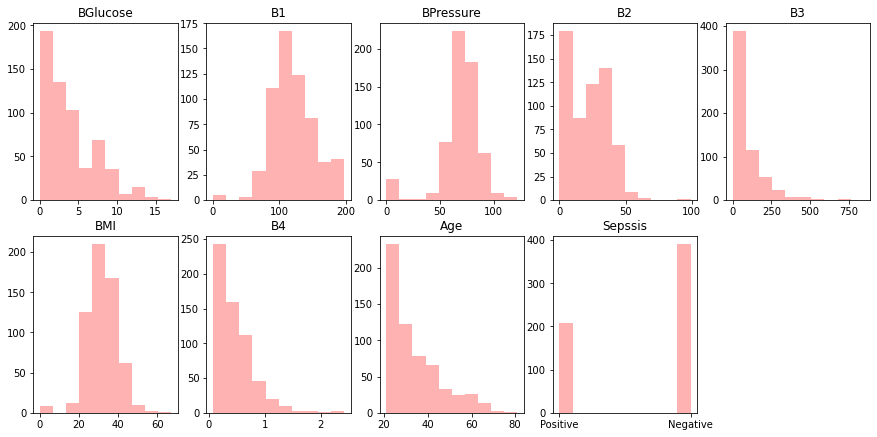

In [8]:
# More visualization to analysis dataset
plt.figure(figsize= (15,15))
n = len(df.columns)

for i, col in enumerate(df.columns):
    plt.subplot(4,5,i+1)
    plt.hist(df[col], alpha=0.3, color="r")
    plt.title(col)

In [9]:
df["Sepssis"] = np.where(df["Sepssis"].str.contains("Positive"), 1, 0)

## 1.4 Non-Linear relationship
According to the correlation diagram, we can conclude that there is no linear relationship to describe the prediction and the features. Although this information is useless to tree-style Machine Learning model, it's very handy for Logistic Regression that later we will design polynomial features to train it.

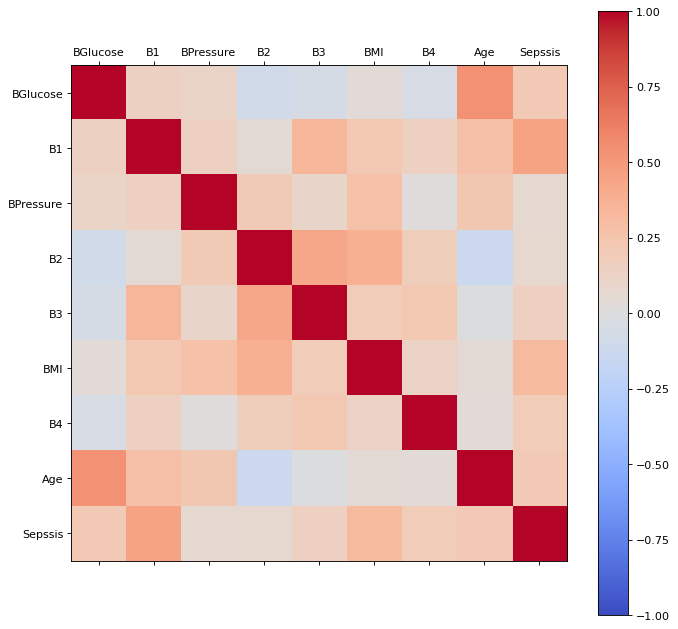

In [10]:
# heatmap
correlations = df.corr()
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap=plt.cm.coolwarm)
fig.colorbar(cax)
ticks = np.arange(0,n,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In [11]:
X = df.drop(columns="Sepssis")

Y = df[['Sepssis']]

print(X.shape)
print(Y.shape)

(599, 8)
(599, 1)


## 1.5 Strange BMI values
It's because BMI is widely known to have a relatively low 18 and up to 39.9 and yet we have 9 entries has BMI = 0. An unacceptable value like such may be resulted from a bad data collection, one way to compensate this loss is to use value of other features to estimate a possible value of this feature BMI, This technique is called K-nearest neighbors, it's believed that variable k approximately equals to the square root of the number of entries, For this experiment it will roughly be 24 and so, 24 data points that are nearest to the missing BMI value is used to estimate the missing.
## 1.6 Outliers
Looking at the boxplot, we can see that our dataset is contaminated by outliers. There's also many methods to deal with this problem, I choose to replace them with 1st percentile for low-bound outliers and 99th percentile for upper-bound outlier, this technique is often known as Winsorization. It's because comparing with a BMI case, we don't have any information about the presence of these outliers so, capping technique is a safe strategy.

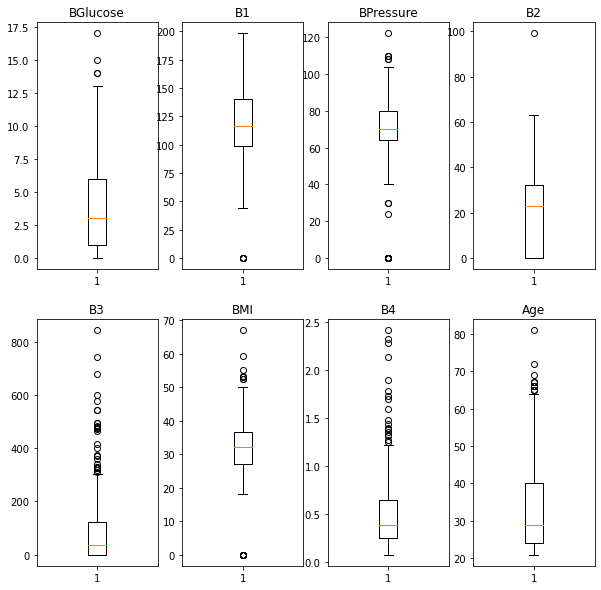

In [12]:

# Boxplot for a range of value
import math
def draw_boxplot(df):
    fig, ax = plt.subplots(2,4,figsize=(10,10))
    for i, col in enumerate(df.columns):
        if math.floor(i / 4) >= len(ax):
            continue
        ax_col = ax[math.floor(i / 4), i % 4]
        ax_col.boxplot(df[col])
        ax_col.set_title(col)
    plt.show()

draw_boxplot(X)

## 1.7 Maximum number of features needed to predict data
PCA analysis proposes that 3 features may already be able to predict 99% accuracy, However, it's very risky to just rely on this information to completely remove features, it recommended to consult with the expert before making decision.
This information will be useful to tune maximum of features of Decision Tree.

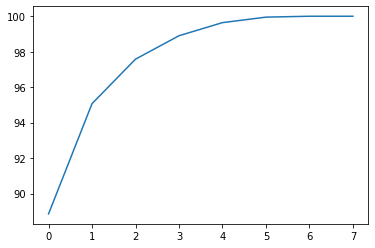

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)

# 2. Data Wrangling
Given the previous analysis of the dataset, we will perform these steps:
1. Spliting dataset into dependent-variable dataframe Y and independent-variable dataframe X
2. Capping outliers to 1st and 99th percentile values
3. Impute strange BMI=0 using KNN

In [14]:
def print_no_0(df):
    for col in df.columns:
        print(f"{col}: {df[col].isin([0]).sum()}")


## Spliting depedent and independent variables

In [15]:
# Encode target value

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y.values.ravel())


print(Y[:5])

[1 0 1 0 1]


## Outliers

In [16]:
import numpy as np
for col in X.columns:
    percentiles = X[col].quantile([0.01, 0.99]).values
    print(f"{col} \t 1st percentile= {percentiles[0]:.3f} \t 99th percentile= {percentiles[1]:.3f}")
    X[col] = np.clip(X[col], percentiles[0], percentiles[1])

BGlucose 	 1st percentile= 0.000 	 99th percentile= 13.000
B1 	 1st percentile= 56.740 	 99th percentile= 196.000
BPressure 	 1st percentile= 0.000 	 99th percentile= 104.080
B2 	 1st percentile= 0.000 	 99th percentile= 52.040
B3 	 1st percentile= 0.000 	 99th percentile= 543.040
BMI 	 1st percentile= 0.000 	 99th percentile= 52.300
B4 	 1st percentile= 0.089 	 99th percentile= 1.732
Age 	 1st percentile= 21.000 	 99th percentile= 66.020


In [17]:
# After capping outliers, how many zero do we have left?
print_no_0(X)

BGlucose: 93
B1: 0
BPressure: 28
B2: 175
B3: 289
BMI: 9
B4: 0
Age: 0


We successfully remove outliers 0 of B1. However there are still weird 0 in BMI so, we will try to imput those missing value using K-NN.

In [18]:
from sklearn.impute import KNNImputer
from math import sqrt
from sklearn.compose import ColumnTransformer

X["BMI"].replace({0:np.nan}, inplace=True)

no_neighbors = int(sqrt(len(X)))
imputer = KNNImputer(n_neighbors=no_neighbors)


X_imput = imputer.fit_transform(X)
X = pd.DataFrame(X_imput, columns=["BGlucose","B1","BPressure", "B2", "B3", "BMI","B4", "Age"])


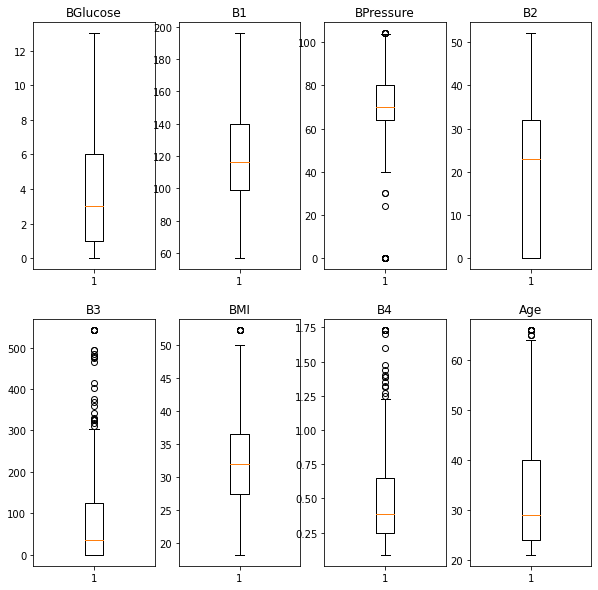

In [38]:
draw_boxplot(X)
# After removing outliers

# 3. Models Developments
We develop 4 Machine Learning models for this experiments and a general process of developing can be described in 3 main steps:
1. Use GridSearch to find hyperparameters for our models that can yield the highest f1 micro score. The cross validation is a 10-fold validation and the process is repeated 3 times. 
2. After finding out the best settings for the model, we will try to compare them together by train it with a same training set and validate with the same validation set. We will use 3 metrics to illustrate a potential peformance of models:
	1. Confusion matrix
	2. ROC-AUC score
	3. Precision-recall curve and its AUC score
4 Machine Learning algorithms we used consist of
2 classic algorithm for classification problems:
1. Logistic Regression
2. Decision Tree
And 2 improved version of Decision Tree
4. Random Forest: overcome Decision Tree's weakness using bagging technique
5. Gradient Boosting: overcome Decision Tree's weakness using boosting technique

**Utils functions**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline as ImPipeline

In [40]:
def draw_confusion_matrix(cnf_matrix):
    class_names=["Positive","Negative"] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [41]:
def print_evaluate_score(y_test, y_pred):
    cnf = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    draw_confusion_matrix(cnf)

In [42]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_validate

from sklearn import model_selection
def print_cross_validate(model):
    scoring = {
              'f1_score' : make_scorer(f1_score),
              'recall' : make_scorer(recall_score), 
              'precision' : make_scorer(precision_score),}

    kfold = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=42)

    results = cross_validate(estimator=model,
                                            X=X,
                                            y=Y,
                                            cv=kfold,
                                            scoring=scoring, return_train_score=False)
                                            
    print("F1-score: %.3f"%results["test_f1_score"].mean())
    print("Precision score: %.3f"%results["test_precision"].mean())
    print("Recall score: %.3f"%results["test_recall"].mean())

In [43]:
from sklearn.metrics import roc_curve
def plot_roc_curve(test_y,model_probs):
	"""
		Plot ROC curve.
	"""
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	plt.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()

In [44]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
def plot_pr_curve(test_y,model_probs):
	"""
	Plot the precision-recall curve.
	Try to find the threshold that returns the best F1 score
	"""
	# # plot model roc curve
	precision, recall, thresholds = precision_recall_curve(test_y, model_probs)
	# ...
	# # convert to f score
	fscore = (2 * precision * recall) / (precision + recall)
	# locate the index of the largest f score
	ix = np.argmax(fscore)
	print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

	display = PrecisionRecallDisplay.from_predictions(test_y, model_probs, name="Model A")
	_ = display.ax_.set_title("2-class Precision-Recall curve")

In [45]:
from sklearn.metrics import confusion_matrix,f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


def print_hold_out_evaluation(model, X, Y):
    """
    Perform a hold-out evaluation using a splits that still keeps the ratio 1:2 of the original dataset 
    so that we can get the closest approximation of model performance 
    when it later train on the original dataset to predict the test dataset.
    """ 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=6, test_size=0.2, stratify=Y) # 
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print_evaluate_score(y_test, pred)

    propa = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, propa)
    print('Model ROC-AUC score: %.3f' % roc_auc)
    # plot roc curves
    # plot_roc_curve(y_test, propa)
    plot_pr_curve(y_test, propa)



In [46]:
def print_searchResult(search):
    """
    
    """
    results_df = pd.DataFrame(search.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    display(results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]][:10])

## 1. Logistic Regression

From the EDA phase we have learned that there is no linear relationship exists among the features we used to train our model; therefore, I will use a polynomial logistic regression. And because we use polynomial features, we can't underestimate the chance of overfitting, I will also use regularization technique to overcome that problem.

I designed baseline logistic regression model:
- solver="liblinear"
    - it's because this algorithm works best for a small dataset


The Machine learning pipeline for Logistic Regression model consists of:
1. Transform inputs to polynomial features. Its degree is a hyperparameter that we will going to use GridSearch to find the best value.
2. Normalize the input value using sklearn's RobustScaler() because it's said to handle outliers well and our dataset happened to have a lots of it.
3. the model


In [47]:
# use polynomial to improve model fitting
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
poly = PolynomialFeatures(degree=1)

# instantiate the model (using the default parameters)
solver = "liblinear"
lr_model = LogisticRegression(C=1, solver= solver, 
max_iter=7000, tol=1e-3,
penalty="l2", random_state=4)

scaler = RobustScaler()

lr_pipe = Pipeline(steps=[("poly",poly),
                            ("scaler",scaler),
                            ("logistic",lr_model)])

In [64]:
# SearchGrid CV
from sklearn.model_selection import GridSearchCV, RepeatedKFold
param_grid = {
    "logistic__C":np.logspace(-1, 1, 10),
    "logistic__penalty":["l1","l2"],
    "poly__degree":[2,3,4]

}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=4)
search = GridSearchCV(lr_pipe, param_grid, scoring="f1_micro",cv=cv)
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.772):
{'logistic__C': 0.2782559402207124, 'logistic__penalty': 'l1', 'poly__degree': 2}


In [67]:
print_searchResult(search)

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.2782559402207124_l1_2,"{'logistic__C': 0.2782559402207124, 'logistic_...",1,0.772373,0.050385
0.16681005372000587_l1_2,"{'logistic__C': 0.16681005372000587, 'logistic...",2,0.770725,0.045142
0.16681005372000587_l1_3,"{'logistic__C': 0.16681005372000587, 'logistic...",3,0.770716,0.039729
0.1_l1_3,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",4,0.770151,0.044135
0.2782559402207124_l1_3,"{'logistic__C': 0.2782559402207124, 'logistic_...",5,0.770132,0.046297
0.46415888336127786_l2_2,"{'logistic__C': 0.46415888336127786, 'logistic...",6,0.769567,0.050142
0.1_l1_2,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",7,0.769049,0.043528
0.46415888336127786_l1_2,"{'logistic__C': 0.46415888336127786, 'logistic...",8,0.768456,0.048683
0.774263682681127_l1_2,"{'logistic__C': 0.774263682681127, 'logistic__...",9,0.767900,0.048808


In [48]:
# logistic__C = search.best_params_["logistic__C"]
# logistic__class_weight = search.best_params_["logistic__class_weight"]
# logistic__penalty = search.best_params_["logistic__penalty"]
# poly_degree = search.best_params_["poly__degree"]
# best_logisticReg = LogisticRegression(
#     penalty= logistic__penalty,
#     C= logistic__C,
#     class_weight=logistic__class_weight,
#     random_state=4,
#     solver= solver,
#     max_iter=7000
# )
# poly = PolynomialFeatures(degree=poly_degree)

best_logisticReg = LogisticRegression(
    penalty= "l1",
    C=0.2782559402207124,
    random_state=4,
    solver= solver,
    max_iter=7000
)
poly = PolynomialFeatures(degree=2)
print(best_logisticReg)

LogisticRegression(C=0.2782559402207124, max_iter=7000, penalty='l1',
                   random_state=4, solver='liblinear')


In [49]:
logistic_pipe = Pipeline(steps=[("poly",poly),("scaler", scaler), ("model",best_logisticReg)])

## 2. Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline


dtree_model = DecisionTreeClassifier(max_features="sqrt", random_state=4, ccp_alpha=0.0032, min_samples_split=2)
steps = [('model', dtree_model)]
dtree_pipe = Pipeline(steps=steps)

In [81]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    # "model__class_weight": [{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45,1:0.55},{0:0.5,1:0.5}],
    "model__class_weight": [{0:1, 1:1.9}, "balanced", {0:0.5,1:0.5}],
    "model__ccp_alpha": np.logspace(-3,1,10),
    "model__max_depth": [2,3,4],
    "model__min_samples_split": [2,3,4,5],

}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=4)
search = GridSearchCV(dtree_pipe, param_grid, scoring="f1_micro",cv=cv, error_score="raise")
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.708):
{'model__ccp_alpha': 0.007742636826811269, 'model__class_weight': {0: 1, 1: 1.9}, 'model__max_depth': 4, 'model__min_samples_split': 2}


In [82]:
print_searchResult(search)

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
"0.007742636826811269_{0: 1, 1: 1.9}_4_3","{'model__ccp_alpha': 0.007742636826811269, 'mo...",1,0.708390,0.060061
"0.007742636826811269_{0: 1, 1: 1.9}_4_2","{'model__ccp_alpha': 0.007742636826811269, 'mo...",1,0.708390,0.060061
"0.007742636826811269_{0: 1, 1: 1.9}_4_5","{'model__ccp_alpha': 0.007742636826811269, 'mo...",3,0.707834,0.059283
"0.007742636826811269_{0: 1, 1: 1.9}_4_4","{'model__ccp_alpha': 0.007742636826811269, 'mo...",3,0.707834,0.059283
0.007742636826811269_balanced_4_2,"{'model__ccp_alpha': 0.007742636826811269, 'mo...",5,0.707815,0.059351
0.007742636826811269_balanced_4_3,"{'model__ccp_alpha': 0.007742636826811269, 'mo...",5,0.707815,0.059351
0.007742636826811269_balanced_4_5,"{'model__ccp_alpha': 0.007742636826811269, 'mo...",7,0.707260,0.058558
0.007742636826811269_balanced_4_4,"{'model__ccp_alpha': 0.007742636826811269, 'mo...",7,0.707260,0.058558
"0.0027825594022071257_{0: 0.5, 1: 0.5}_2_3","{'model__ccp_alpha': 0.0027825594022071257, 'm...",9,0.705019,0.053265


In [51]:
# b_params = search.best_params_
# model__class_weight = b_params["model__class_weight"]
# model__ccp_alpha = b_params["model__ccp_alpha"]
# model__max_depth = b_params["model__max_depth"]
# model__min_samples_leaf = b_params["model__min_samples_leaf"]

# dtree_model = DecisionTreeClassifier(max_features="sqrt",
# class_weight=model__class_weight, 
# random_state=4, 
# ccp_alpha=model__ccp_alpha,
# max_depth=model__max_depth,
# min_samples_leaf=model__min_samples_leaf)

dtree_model = DecisionTreeClassifier(max_features="sqrt",
class_weight={0: 1, 1: 1.9}, 
random_state=4, 
ccp_alpha=0.007742636826811269,
max_depth=4,
min_samples_split=2)

steps = [('model', dtree_model)]

dtree_pipe = Pipeline(steps=steps)


## 4. Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_features="sqrt",random_state=3,class_weight={0:0.22, 1: 0.78}, n_jobs=-1)

In [283]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "n_estimators": [100,120,130],
    "class_weight": [{0:1, 1:1.9},"balanced",{0:0.5,1:0.5}],
    "max_depth": [2,3,4, None],
    "min_samples_split": [2,3,],
    "max_features":["sqrt"]

}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=4)
search = GridSearchCV(rf_model, param_grid, scoring="f1_micro",cv=cv, error_score="raise")
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.763):
{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [21]:
# b_params = search.best_params_
# n_estimators = b_params["n_estimators"]
# class_weight = b_params["class_weight"]
# ccp_alpha = b_params["ccp_alpha"]
# max_depth = b_params["max_depth"]
# min_samples_leaf = b_params["min_samples_leaf"]
# min_samples_split = b_params["min_samples_split"]

# rf_model = RandomForestClassifier(max_features="sqrt",
#                             random_state=3,
#                             class_weight=class_weight, 
#                             ccp_alpha= ccp_alpha,
#                             max_depth= max_depth,
#                             min_samples_leaf= min_samples_leaf,
#                             min_samples_split= min_samples_split,
#                             n_jobs=-1)

rf_model = RandomForestClassifier(
                            max_features="sqrt",
                            random_state=3,
                            n_estimators=100,
                            class_weight={0: 0.5, 1: 0.5}, 
                            max_depth= 4,
                            min_samples_split= 3,
                            n_jobs=-1)

In [105]:
print_searchResult(search)

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
"{0: 0.5, 1: 0.5}_4_sqrt_3_100","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",1,0.762881,0.045352
"{0: 0.5, 1: 0.5}_4_sqrt_2_130","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",2,0.761780,0.047204
"{0: 0.5, 1: 0.5}_4_sqrt_2_120","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",3,0.761215,0.046295
"{0: 0.5, 1: 0.5}_4_sqrt_3_120","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",4,0.761215,0.044459
"{0: 0.5, 1: 0.5}_4_sqrt_3_130","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",5,0.760669,0.048624
"{0: 0.5, 1: 0.5}_4_sqrt_2_100","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",6,0.760650,0.047580
"{0: 0.5, 1: 0.5}_None_sqrt_3_100","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",7,0.756224,0.048982
"{0: 0.5, 1: 0.5}_None_sqrt_2_120","{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth'...",8,0.756205,0.049296
"{0: 1, 1: 1.9}_None_sqrt_2_120","{'class_weight': {0: 1, 1: 1.9}, 'max_depth': ...",9,0.755687,0.047911


## 5. Boosting


In [37]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.4, max_depth=1, random_state=0)


In [113]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "n_estimators": [50,70, 100],
    "max_features": ["sqrt",],
    "min_samples_split": [2,3,4],
    "max_depth": [1,2]
    
}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=4)
search = GridSearchCV(clf, param_grid, scoring="f1_micro",cv=cv, error_score="raise")
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.755):
{'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 70}


In [114]:
print_searchResult(search)
# Confidence interval of the model is reasonably good.

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_sqrt_2_70,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",1,0.754567,0.045546
1_sqrt_4_70,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",1,0.754567,0.045546
1_sqrt_3_70,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",1,0.754567,0.045546
1_sqrt_2_50,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",4,0.753437,0.043657
1_sqrt_3_50,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",4,0.753437,0.043657
1_sqrt_4_50,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",4,0.753437,0.043657
1_sqrt_4_100,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",7,0.751243,0.045083
1_sqrt_2_100,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",7,0.751243,0.045083
1_sqrt_3_100,"{'max_depth': 1, 'max_features': 'sqrt', 'min_...",7,0.751243,0.045083


In [38]:
gb_model = GradientBoostingClassifier(
        n_estimators=70, 
        learning_rate=0.4, 
        max_depth=1, 
        random_state=0, 
        max_features="sqrt",
        min_samples_split=2,
        )

# 3. Model Comparison

===LOGISTIC REGRESSION===
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        78
           1       0.83      0.57      0.68        42

    accuracy                           0.81       120
   macro avg       0.81      0.75      0.77       120
weighted avg       0.81      0.81      0.80       120



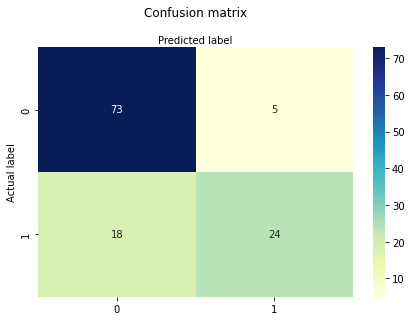

Model ROC-AUC score: 0.888
Best Threshold=0.384281, F-Score=0.744


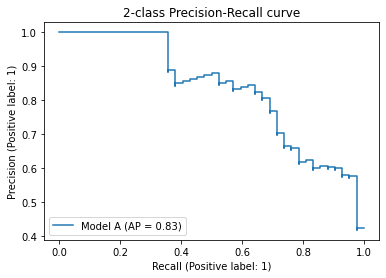

In [56]:
print("===LOGISTIC REGRESSION===")
print_hold_out_evaluation(logistic_pipe, X, Y)

===DECISION TREE===
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        78
           1       0.61      0.74      0.67        42

    accuracy                           0.74       120
   macro avg       0.72      0.74      0.73       120
weighted avg       0.76      0.74      0.75       120



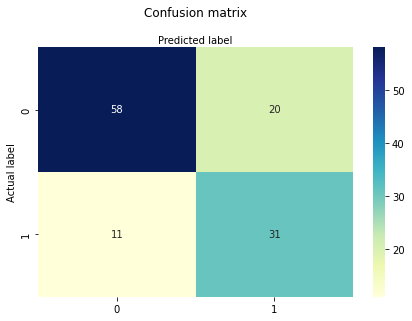

Model ROC-AUC score: 0.783
Best Threshold=0.399399, F-Score=0.694


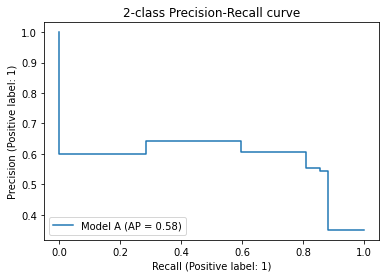

In [57]:

print("===DECISION TREE===")
print_hold_out_evaluation(dtree_pipe, X, Y)


===RANDOM FOREST===
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        78
           1       0.85      0.52      0.65        42

    accuracy                           0.80       120
   macro avg       0.82      0.74      0.75       120
weighted avg       0.81      0.80      0.79       120



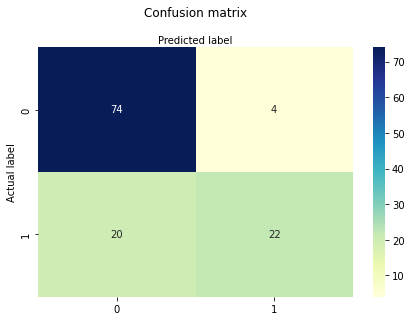

Model ROC-AUC score: 0.897
Best Threshold=0.345814, F-Score=0.787


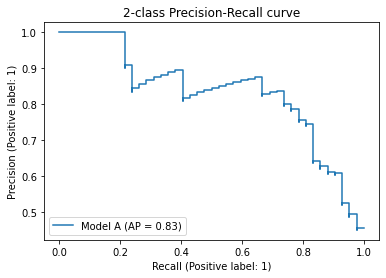

In [58]:

print("===RANDOM FOREST===")
print_hold_out_evaluation(rf_model, X, Y)

===GRADIENT BOOSTING DECISION TREE===
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        78
           1       0.86      0.60      0.70        42

    accuracy                           0.82       120
   macro avg       0.84      0.77      0.79       120
weighted avg       0.83      0.82      0.82       120



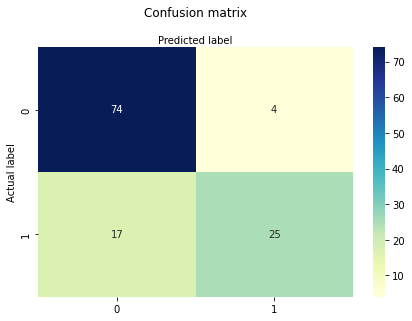

Model ROC-AUC score: 0.855
Best Threshold=0.257375, F-Score=0.742


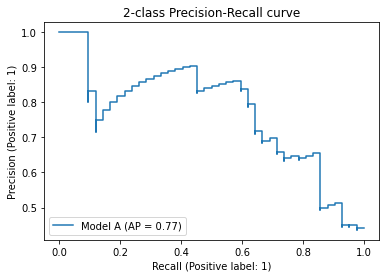

In [59]:

print("===GRADIENT BOOSTING DECISION TREE===")
print_hold_out_evaluation(gb_model, X, Y)

# 4. Evaluation

| Metrics     | Logistic                                                | Decision Tree           | Random Forest                                | Gradient Boost                             |
| ----------- | ------------------------------------------------------- | ----------------------- | -------------------------------------------- | ------------------------------------------ |
| cv-f1-micro | 0772 (+- 0.050)                                         | 0.708  (+- 0.060)       | 0.763   (+- 0.045)                           | 0.755 (+- 0.045)                           |
| roc-auc     | 0.888                                                   | 0.783                   | 0.897   (Very confident with its prediction) | 0.855                                      |
| pr-auc      | 0.83                                                    | 0.583 (struggling)      | 0.830                                        | 0.777                                      |
| Pros        | Excellent at predicting (-) class, and precise with (+) | Suprisingly good at (+) | (-) is excellent while (+) is very precise   | Short training time, Best average F1 score |
| Cons        | Slow tuning, and high false negative (top-2)               | High false positive     | High false negative (top-1)                     | High false negative  (top-2)                  |
|             |                                                         |                         |                                              |                                            |


**Disclaimer**: the hold-out dataset is not a representative of the real training set and testing set, but I tried to get as close as possible to it so we can have a general idea of these candidate models' performance.

## Ultimate Judgement
Overall, the Random Forest model is the best model I developed due to its consistently good performance. Although according the last evaluation, it seems to suffer quite high false negative rate, its excellent prediction of class negative and precise prediction of class positive is a key attribute that let it become our final model. Logistic Regression model and Gradient Boosting model also produce a competitive numbers but based on the AUC score, Random Forest is believed to get a well balance of sensitivity and specificity.

# Generate Test Result

In [39]:
the_best = gb_model

In [40]:
import pandas as pd
testset = pd.read_csv("Paitients_Files_Test.csv")
testset.rename(columns=column_names, inplace=True)
id_col = testset["ID"]
testset.drop(columns=["ID","Insurance"], inplace=True)
testset.head()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
0,1,109,38,18,120,23.1,0.407,26
1,1,108,88,19,0,27.1,0.400,24
2,6,96,0,0,0,23.7,0.190,28
3,1,124,74,36,0,27.8,0.100,30
4,7,150,78,29,126,35.2,0.692,54


In [41]:
the_best.fit(X, Y)


GradientBoostingClassifier(learning_rate=0.4, max_depth=1, max_features='sqrt',
                           n_estimators=70, random_state=0)

In [42]:
pred_test = the_best.predict(testset)

In [26]:
mythreshold = 0.4
decisions = (the_best.predict_proba(testset)[:,1] >= mythreshold).astype(int)
decisions


array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
result_to_csv = pd.DataFrame(decisions)


In [44]:
result_to_csv = pd.concat([id_col, pd.Series(pred_test)], axis=1)
result_to_csv.rename(columns={0: "Sepssis"}, inplace=True)
result_to_csv.head()

,ID,Sepssis
0,ICU200609,0
1,ICU200610,0
2,ICU200611,0
3,ICU200612,0
4,ICU200613,1


In [45]:
result_to_csv.groupby("Sepssis").count()

,ID
Sepssis,
0,115
1,54


In [26]:
result_to_csv.to_csv("COSC2753_A1_Predictions_S3804803.csv", index=False)

# Reference
- [Optimize Sepsis managment in ICU](https://www.radiometer.com/en/about-radiometer/news/optimizing-sepsis-management-in-the-intensive-care-unit)
- [BMI](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)
- [Robust Scaler](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)
- [Winsorization](https://www.listendata.com/2015/01/detecting-and-solving-problem-of-outlier.html)
- [Cost sensitive Decision tree](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/)
- [Gradient Boosting of sklearn](https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/#Gradient-Boosting-Decision-Trees)